## Basic Model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#from fastai import 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import fastai

from fastai.layers import BCEWithLogitsFlat
from fastai.vision import unet_learner, models
from fastai.vision import lr_find
from fastai.vision import Path, get_image_files, open_image, open_mask, SegmentationItemList, get_transforms, imagenet_stats
from fastai.metrics import dice


In [3]:
path = Path('data')
train = pd.read_csv("data/train.csv")
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

In [4]:
unique_images = train.iloc[::4, :]

In [5]:
fnames = get_image_files(path/'train_images')
fnames[:3]

[PosixPath('data/train_images/3f611b8.jpg'),
 PosixPath('data/train_images/86c38ed.jpg'),
 PosixPath('data/train_images/3d64d9d.jpg')]

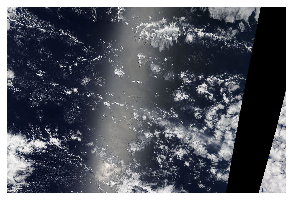

In [6]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [7]:
import PIL
from fastai.vision import ImageSegment
from fastai.vision import SegmentationLabelList
from fastai.vision import warnings, pil2tensor

# Our masks are overlapping so we've represented the masks as 4-channel images
# This is convenient for us because we can still store them in standard RGBA images
# However we have to make sure we load these images as RGBA in order for them to work
def custom_open_mask(filename, div=False, convert_mode='L', after_open=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(filename).convert('RGBA')
    
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
        
    return ImageSegment(x)
    

def custom_open(self, fn):
    return custom_open_mask(fn)
    
#Open image with our custom method
SegmentationLabelList.open = custom_open

In [8]:
def get_y_fn(x):
    split = x.split('/')
    
    return Path('data/train_images_annots/')/split[-1].replace('.jpg','.png')

codes = np.array(['Fish', 'Flower', 'Gravel', 'Sugar'])

In [9]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)

In [10]:
train_ids = 'data/train_images/' + train_ids
valid_ids = 'data/train_images/' + valid_ids

In [11]:
def isValid(img_id):
    return str(img_id) in valid_ids

In [12]:
subset = unique_images.iloc[:8].append(unique_images[unique_images['im_id'] == '446a3d6.jpg'])

In [13]:
src = (SegmentationItemList.from_df(unique_images, path/'train_images', cols='im_id')
       .split_by_valid_func(isValid)
       .label_from_func(get_y_fn, classes=codes))

In [14]:
'data/train_images/446a3d6.jpg' in src.train.items

True

In [15]:
bs=4
size =(350,525)

In [16]:
data = (src.transform(get_transforms(), tfm_y=True, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

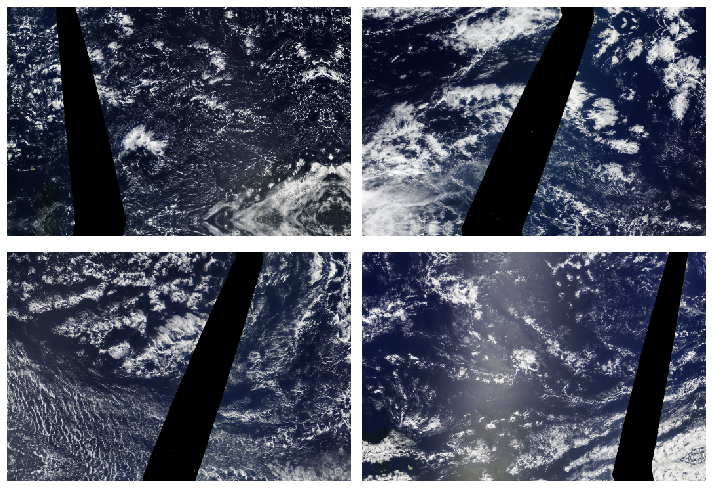

In [17]:
data.show_batch(5, figsize=(10,7))

In [18]:
data

ImageDataBunch;

Train: LabelList (4991 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: SegmentationLabelList
ImageSegment (4, 350, 525),ImageSegment (4, 350, 525),ImageSegment (4, 350, 525),ImageSegment (4, 350, 525),ImageSegment (4, 350, 525)
Path: data/train_images;

Valid: LabelList (555 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: SegmentationLabelList
ImageSegment (4, 350, 525),ImageSegment (4, 350, 525),ImageSegment (4, 350, 525),ImageSegment (4, 350, 525),ImageSegment (4, 350, 525)
Path: data/train_images;

Test: None

In [19]:
from fastai.torch_core import *
from fastai.callback import *
from fastai.layers import *
from fastai.basic_train import LearnerCallback


In [20]:
def mutliclass_dice(logits, targets, iou=False, eps=1e-8):
    """
    Dice coefficient metric for multiclass binary target. 
    If iou=True, returns iou metric, classic for segmentation problems.
    """
    
    n = targets.shape[0]   #Batch size of 4
    
    #Flatten logits and targets
    logits = logits.view(n,-1)  
    targets = targets.view(n,-1).float()
    
    #Convert logits to probabilities
    probs = torch.sigmoid(logits)
    x = probs * targets
    intersect = (probs * targets).sum(dim=1).float()
    union = (probs + targets).sum(dim=1).float()
    
    if not iou: 
        l = 2. * intersect / union
    else: 
        l = intersect / (union-intersect+eps)
        
    # The Dice coefficient is defined to be 1 when both X and Y are empty.
    l[union == 0.] = 1.
    return l.mean()

In [21]:
learn = unet_learner(data, models.resnet18, metrics=[mutliclass_dice], loss_func=BCEWithLogitsFlat())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


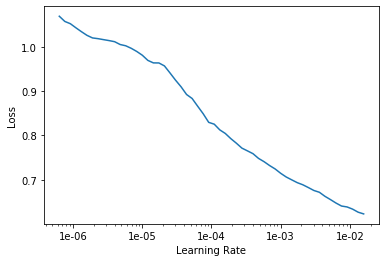

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=3e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice,time
0,0.400696,0.375986,0.202669,07:52
